## 期末專案：**針對安全信件**之情緒分析（Lexicon)
Last modified: 陳文薇（2024/05/29）<br>


#### 大綱
1. 載入套件說明
2. 資料前處理、詞頻
3. 只針對釣魚信件lexicon-base 情緒分析
  + 3.1 準備LIWC情緒字典
  + 3.2 情緒字典與斷詞結果進行合併
  + 3.3 正負向情緒分數聲量長條圖
  + 3.4 正負向情緒分數聲量密度圖
  + 3.5 正負向情緒分數比例箱型圖
  + 3.6 正負向情緒分數聲量長條圖(去除離群值與離群值用平均替代)
  + 3.7 情緒代表字
    + 第12501封之正負相情緒代表字
  + 3.6 各封情緒分數

## <font color=#ffa>套件載入</font>

In [1]:
!pip install plotly
!pip install seaborn

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [92]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt
from collections import Counter

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chenwenwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### <font color=#ffa>--------資料前處理開始--------
用 nltk 套件做斷句、斷詞、stemming
資料集：18650封信件
資料來源：https://www.kaggle.com/datasets/subhajournal/phishingemails/data
</font>

In [4]:
maildata = pd.read_csv("./dataset/Phishing_Email.csv")
df = maildata
print(df.shape)

(18650, 3)


In [5]:
# 斷句
maildata = maildata.assign(sentence = maildata['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
maildata['sentence'] = maildata["sentence"].str.replace(r'[\d]+', '', regex=True).astype(str) #去除數字
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格


# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
maildata = maildata[maildata["sentence"] != "empty"]
maildata = maildata[maildata["sentence"] != "nan"]

# 斷詞
token_df = maildata.assign(token = maildata['sentence'].apply(nltk.word_tokenize)).explode('token').reset_index(drop=True)

# 轉成小寫
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())

In [6]:
# stemming
# porter = PorterStemmer()
# mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(porter.stem)).reset_index(drop=True)

# lemmatization
lm = WordNetLemmatizer()
mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(lm.lemmatize)).reset_index(drop=True)


In [7]:
# 將不必要的欄位 以及 nan 刪掉
tidy_mails_df = mails_df.drop(columns=["token", "word"])
tidy_mails_df = tidy_mails_df.rename(columns={"Unnamed: 0":"index", "stem_token":"word"})
tidy_mails_df = tidy_mails_df[tidy_mails_df['word'] != 'nan']

In [8]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(word) <= 1

tidy_mails_df = tidy_mails_df[~tidy_mails_df['word'].apply(is_single_english_letter)]

In [9]:
tidy_mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6836675 entries, 0 to 7318687
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   Email Text  object
 2   Email Type  object
 3   sentence    object
 4   word        object
dtypes: int64(1), object(4)
memory usage: 313.0+ MB


In [10]:
tidy_mails_df.head(5)

,index,Email Text,Email Type,sentence,word
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,re,re
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
3,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,re
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex


### 移除停用字

In [11]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenwenwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

In [13]:
noStop_df = tidy_mails_df[~tidy_mails_df['word'].isin(stops)]
noStop_df

,index,Email Text,Email Type,sentence,word
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex
5,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,lang
6,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,dick
...,...,...,...,...,...
7318683,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,team
7318684,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kind
7318685,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,regard
7318686,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kuldeep


### <font color=#ffa>--------資料前處理結束--------
</font>

## 計算詞頻
下面分為全部字的詞頻、Phishing mail詞頻、Safe mail詞頻

### 總信件字詞頻（刪除停用字後）

In [14]:
freq_noStop_df = pd.DataFrame(noStop_df['word'].value_counts()).reset_index()
freq_noStop_df.columns = ['word', 'freq']
freq_noStop_df.head(30)

,word,freq
0,language,23428
1,enron,19274
2,university,17510
3,information,14703
4,please,13774
5,new,13373
6,subject,12514
7,time,11610
8,company,11540
9,address,11488


freq_noStop_df.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

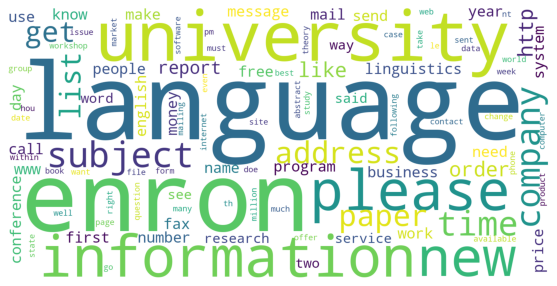

In [15]:
text = freq_noStop_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從總信件的詞頻長條圖與文字雲可看出：<br>
1. enron這家公司很常被提到，可能是與安隆事件相關（當年安隆事件的電子郵件至今仍大量散佈在網路上）<br>
2. language也很常出現，可能是因為幾乎每封電子郵件中的廣告都能讓使用者設定語言<br>

接下來會看phishing與safe信件的差異

### Phishing mail 詞頻

In [16]:
final_phishing = noStop_df[noStop_df['Email Type'] == 'Phishing Email']

In [17]:
freq_phishing = pd.DataFrame(final_phishing['word'].value_counts()).reset_index()
freq_phishing.columns = ['word', 'freq']
freq_phishing.head(30)

,word,freq
0,company,5117
1,free,4331
2,get,3985
3,report,3899
4,business,3848
5,please,3844
6,information,3842
7,money,3789
8,order,3687
9,address,3640


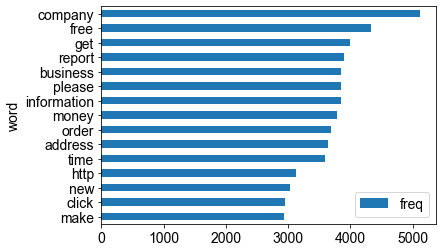

In [18]:
freq_phishing.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

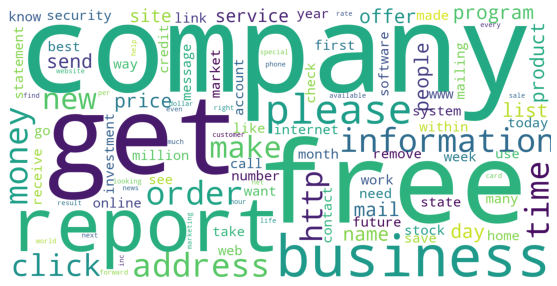

In [19]:
text = freq_phishing.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從phishing信件的詞頻長條圖與文字雲可看出：<br>
1. company很常被提到，可能是部分釣魚信件會偽裝成公司發出<br>
2. free、get、click、money出現頻率很高，推測釣魚信件中經常與金錢有關，且會請使用者點擊連結<br>


### Safe mail 詞頻

In [20]:
final_safe = noStop_df[noStop_df['Email Type'] == 'Safe Email']

In [21]:
freq_safe = pd.DataFrame(final_safe['word'].value_counts()).reset_index()
freq_safe.columns = ['word', 'freq']
freq_safe.head(30)

,word,freq
0,language,23332
1,enron,19271
2,university,17404
3,subject,11429
4,paper,10974
5,information,10861
6,new,10345
7,please,9930
8,linguistics,8908
9,conference,8406


freq_safe.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

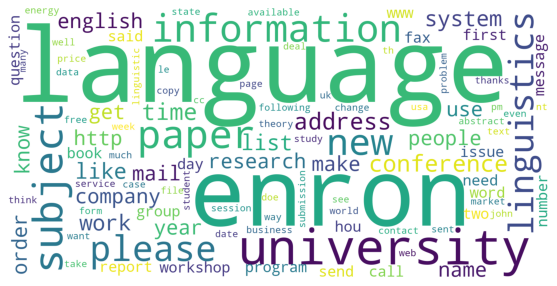

In [22]:
text = freq_safe.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從safe信件的詞頻長條圖與文字雲可看出，基本上phishing信件的高頻詞彙在safe信件中都不常出現，因此推測可用phishing信件的詞頻與文字雲來當作過濾釣魚信件的依據。

## 安全信件種類情緒分析開始

In [23]:
# 讀取情緒字典
en_dict_path = "./dict/liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

In [24]:
our_liwc_df = pd.merge(final_safe, liwc_dict, how="left")
our_liwc_df.head(3)

,index,Email Text,Email Type,sentence,word,sentiments
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc,NaN
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism,NaN
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex,NaN


計算每封信件的情緒總和

In [81]:
our_liwc_df['sentiments'] = our_liwc_df['sentiments'].fillna('NaN')
# 使用 groupby 來計算每個 index 和 sentiment 的大小
sentiment_count = our_liwc_df.groupby(['index', 'sentiments']).size().reset_index(name='size')
# 將特殊值還原為 NaN
sentiment_count['sentiments'] = sentiment_count['sentiments'].replace('<NA>', 'NaN')
sentiment_count = sentiment_count.rename(columns={0: 'size'})

sentiment_count

,index,sentiments,size
0,0,NaN,74
1,0,affect,2
2,0,positive,2
3,1,NaN,36
4,1,affect,2
...,...,...,...
39737,18648,affect,6
39738,18648,positive,6
39739,18649,NaN,20
39740,18649,affect,2


### 正負向情緒分數聲量長條
分別畫出信件中，正向（positive）與負向（negative）情緒的折線圖

In [84]:
#合併
pos_tmp = sentiment_count[sentiment_count['sentiments']=='positive']
neg_tmp = sentiment_count[sentiment_count['sentiments']=='negative']
df_tmp = pd.merge(pos_tmp, neg_tmp, on="index", how="outer", suffixes=('_pos', '_neg'))
#以下為了讓列數一致，否則下面的圖會跑錯
pos = df_tmp[['index', 'sentiments_pos', 'size_pos']].fillna({'sentiments_pos': 'positive', 'size_pos': 0})
pos.rename(columns={'sentiments_pos': 'sentiments', 'size_pos': 'size'}, inplace=True)
neg = df_tmp[['index', 'sentiments_neg', 'size_neg']].fillna({'sentiments_neg': 'negative', 'size_neg': 0})
neg.rename(columns={'sentiments_neg': 'sentiments', 'size_neg': 'size'}, inplace=True)
print(pos.head(3))
print(neg.head(3))

   index sentiments  size
0      0   positive   2.0
1      1   positive   1.0
2      2   positive   2.0
   index sentiments  size
0      0   negative   0.0
1      1   negative   1.0
2      2   negative   0.0


### 密度圖

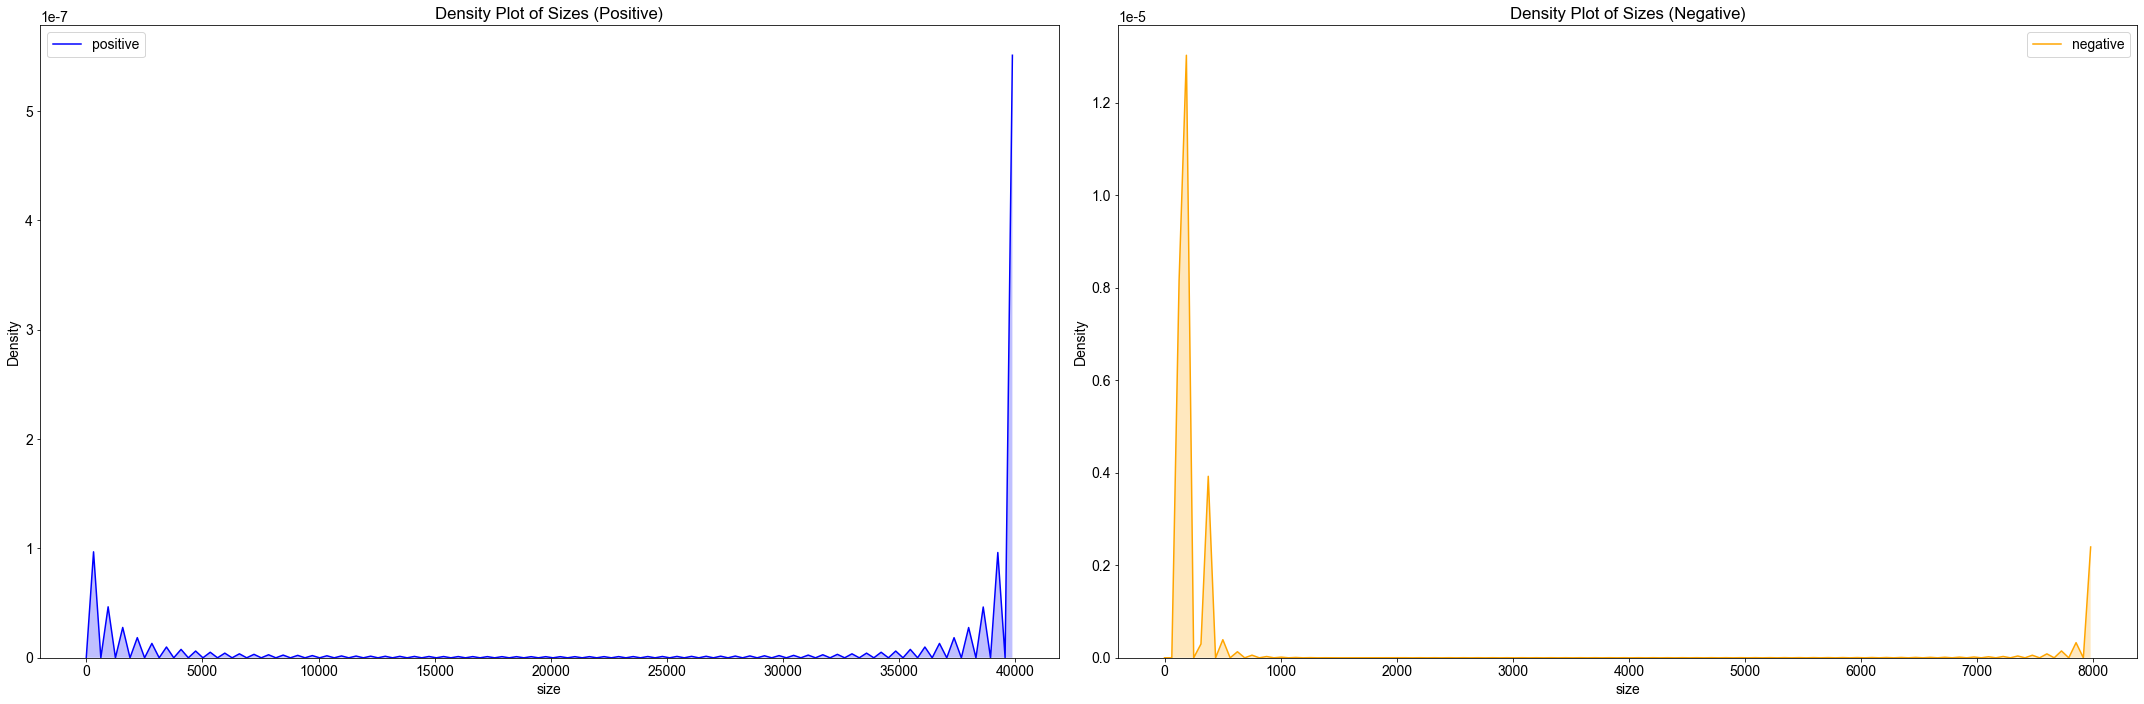

In [85]:
# 創建子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# 繪製第一個密度圖（pos）
sns.kdeplot(pos['size'], color="blue", shade=True, label="positive", ax=ax1)
ax1.set_xlabel('size')
ax1.set_ylabel('Density')
ax1.set_title('Density Plot of Sizes (Positive)')
ax1.legend()

# 繪製第二個密度圖（neg）
sns.kdeplot(neg['size'], color="orange", shade=True, label="negative", ax=ax2)
ax2.set_xlabel('size')
ax2.set_ylabel('Density')
ax2.set_title('Density Plot of Sizes (Negative)')
ax2.legend()

# 調整佈局
plt.tight_layout()
plt.show()

#### 箱形圖

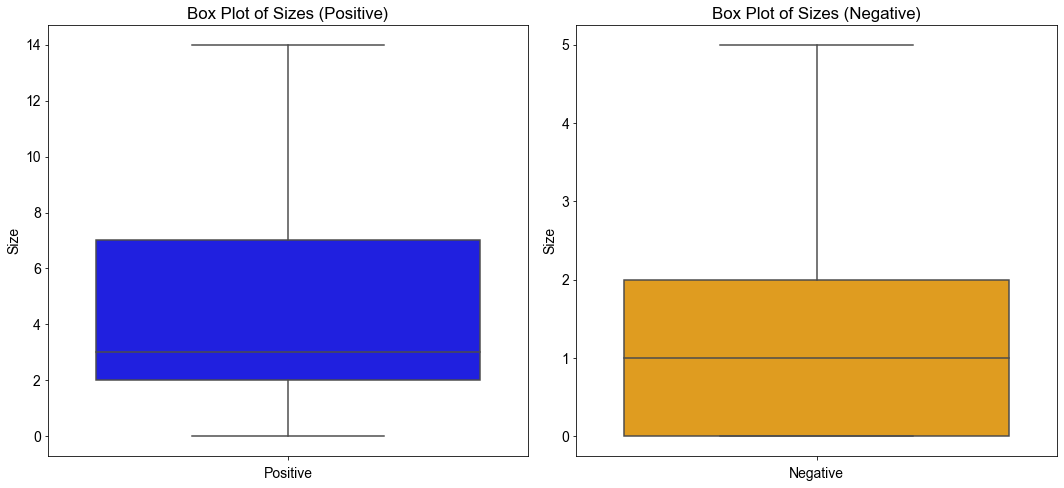

In [86]:
# 創建子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# 繪製第一個箱型圖（pos），去除離群值
sns.boxplot(y=pos['size'], ax=ax1, color="blue", showfliers=False)
ax1.set_xlabel('Positive')
ax1.set_ylabel('Size')
ax1.set_title('Box Plot of Sizes (Positive)')

# 繪製第二個箱型圖（neg），去除離群值
sns.boxplot(y=neg['size'], ax=ax2, color="orange", showfliers=False)
ax2.set_xlabel('Negative')
ax2.set_ylabel('Size')
ax2.set_title('Box Plot of Sizes (Negative)')

# 調整佈局
plt.tight_layout()
plt.show()


由箱型圖結果可知，positive的整體分布比較多一些，代表在安全信件中整體情緒是偏正向的。

#### 長條堆疊圖（去除離群值）

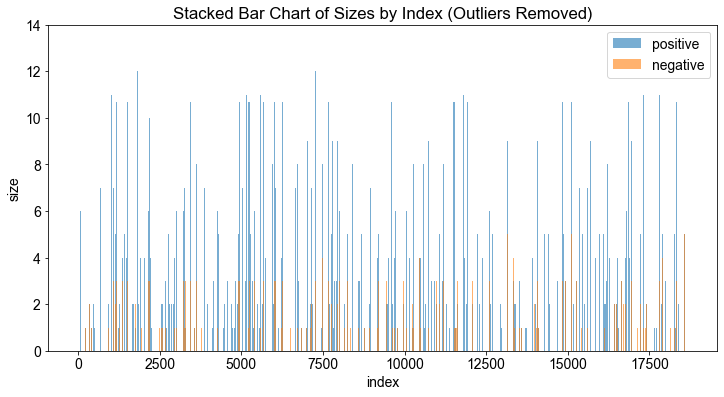

In [32]:
# 計算四分位數和四分位距
Q1_pos = pos['size'].quantile(0.25)
Q3_pos = pos['size'].quantile(0.75)
IQR_pos = Q3_pos - Q1_pos

Q1_neg = neg['size'].quantile(0.25)
Q3_neg = neg['size'].quantile(0.75)
IQR_neg = Q3_neg - Q1_neg

# 定義範圍
lower_bound_pos = Q1_pos - 1.5 * IQR_pos
upper_bound_pos = Q3_pos + 1.5 * IQR_pos

lower_bound_neg = Q1_neg - 1.5 * IQR_neg
upper_bound_neg = Q3_neg + 1.5 * IQR_neg

# 去除離群值
pos_filtered = pos[(pos['size'] >= lower_bound_pos) & (pos['size'] <= upper_bound_pos)]
neg_filtered = neg[(neg['size'] >= lower_bound_neg) & (neg['size'] <= upper_bound_neg)]

# 繪製堆疊條形圖
colors = ["tab:blue", "tab:orange"]
fig, ax = plt.subplots(figsize=(12, 6))

# 獲取最大值來設置 y 軸範圍
max_value = max(pos_filtered['size'].max(), neg_filtered['size'].max())
ax.set_ylim(0, max_value)

# 繪製條形圖
ax.bar(pos_filtered['index'], pos_filtered['size'], color=colors[0], alpha=0.6, align='center', label='positive')
ax.bar(neg_filtered['index'], neg_filtered['size'], color=colors[1], alpha=0.6, align='center', label='negative')

plt.xlabel('index')
plt.ylabel('size')
ax.legend(loc='upper right')
plt.title('Stacked Bar Chart of Sizes by Index (Outliers Removed)')
plt.show()

In [89]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("index")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(5)

,index,sentiments,size,ratio
0,0,NaN,74,0.948718
1,0,affect,2,0.025641
2,0,positive,2,0.025641
3,1,NaN,36,0.900000
4,1,affect,2,0.050000


#### 利用ratio繪製的情緒長條堆疊圖（去除離群值）

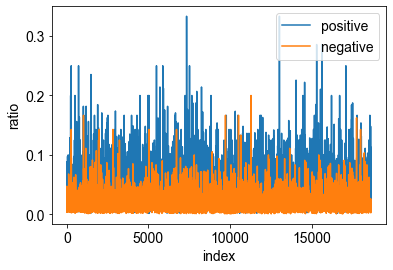

In [91]:
# 計算四分位數和四分位距
Q1_pos = pos['ratio'].quantile(0.25)
Q3_pos = pos['ratio'].quantile(0.75)
IQR_pos = Q3_pos - Q1_pos

Q1_neg = neg['ratio'].quantile(0.25)
Q3_neg = neg['ratio'].quantile(0.75)
IQR_neg = Q3_neg - Q1_neg

# 定義範圍
lower_bound_pos = Q1_pos - 1.5 * IQR_pos
upper_bound_pos = Q3_pos + 1.5 * IQR_pos

lower_bound_neg = Q1_neg - 1.5 * IQR_neg
upper_bound_neg = Q3_neg + 1.5 * IQR_neg

# 去除離群值
pos_filtered = pos[(pos['ratio'] >= lower_bound_pos) & (pos['ratio'] <= upper_bound_pos)]
neg_filtered = neg[(neg['ratio'] >= lower_bound_neg) & (neg['ratio'] <= upper_bound_neg)]

fig, ax = plt.subplots()

ax.plot(pos['index'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['index'],
       neg['ratio'], 
       color = colors[1])
plt.xlabel('index')
plt.ylabel('ratio')

ax.legend(['positive','negative'], loc ='upper right') 

 -------安全信件種類情緒分析結束-------

### 情緒代表字

In [55]:
word_count = our_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False)

,word,sentiments,size
54672,language,NaN,23332
27022,enron,NaN,19271
99621,university,NaN,17404
91403,subject,NaN,11429
70724,paper,NaN,10974
...,...,...,...
42925,httpwwwbestnlwebloghtml,NaN,1
42924,httpwwwberrytalkcommtmain,NaN,1
42923,httpwwwberniewebnetlimbo,NaN,1
42922,httpwwwberniewebnetjournal,NaN,1


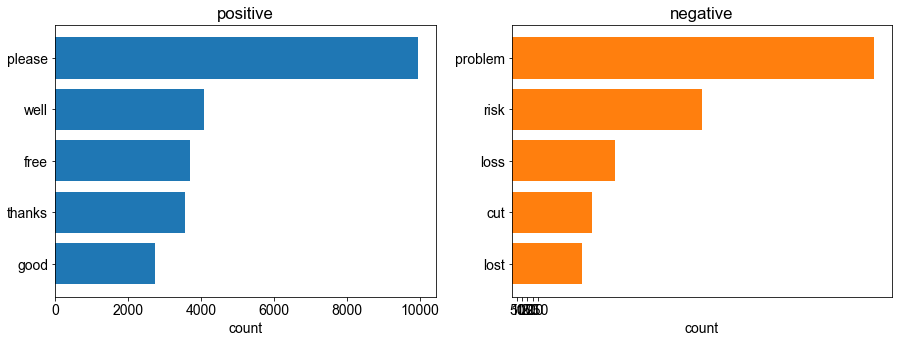

In [56]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175]) 
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

這裡的barh與釣魚信件產生的結果相似

#### 第12501封之正負向情緒代表字

In [57]:
mask = (our_liwc_df['index']==12501) & (~our_liwc_df['sentiments'].isna())
word_count_14275 = our_liwc_df.loc[mask, ['word','sentiments']]
word_count_14275 = word_count_14275.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_14275.sort_values('size',ascending=False)

,word,sentiments,size
25550,language,NaN,15340
47888,university,NaN,11250
33706,paper,NaN,7006
43814,subject,NaN,6578
26566,linguistics,NaN,5940
...,...,...,...
47113,typeerror,NaN,1
47209,ubm,NaN,1
11424,dfto,NaN,1
45448,textplain,NaN,1


Text(0.5, 0, 'count')

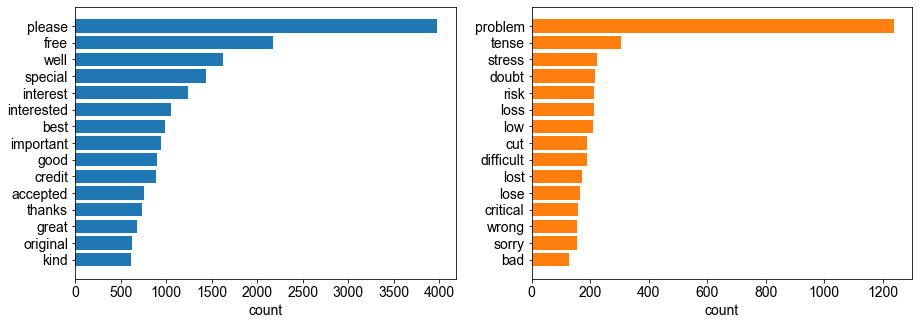

In [58]:
pos = word_count_14275[word_count_14275['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_14275[word_count_14275['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')

### 各封情緒分數

In [65]:
sentiment_count

,index,sentiments,size,ratio
0,0,NaN,74,0.948718
1,0,affect,2,0.025641
2,0,positive,2,0.025641
3,1,NaN,36,0.900000
4,1,affect,2,0.050000
...,...,...,...,...
39737,18648,affect,6,0.056604
39738,18648,positive,6,0.056604
39739,18649,NaN,20,0.833333
39740,18649,affect,2,0.083333


In [66]:
mask = ~our_liwc_df['sentiments'].isna()
our_sentiment_value = sentiment_count.pivot_table(index='index', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
our_sentiment_value.head()

,index,NaN,affect,anger,anx,negative,positive,sad
0,0,74,2,0,0,0,2,0
1,1,36,2,0,0,1,1,0
2,2,103,2,0,0,0,2,0
3,5,266,28,1,15,16,12,0
4,6,76,3,0,0,2,1,1


In [77]:
# sentiment 計算方式: positive - anger - anx - negative - sad
our_sentiment_value["sentiment_value"] = (
    our_sentiment_value["positive"]
    - our_sentiment_value["anger"]
    - our_sentiment_value["anx"]
    - our_sentiment_value["negative"]
    - our_sentiment_value["sad"]
)
our_sentiment_value.sort_values(by="sentiment_value", ascending=False)

,index,NaN,affect,anger,anx,negative,positive,sad,sentiment_value
7448,12501,1339056,48860,1004,1528,7978,39880,1892,27478
9650,16203,6854,224,4,0,29,191,3,155
10092,16939,6276,382,23,20,106,268,30,89
6433,10805,7652,337,4,24,109,228,10,81
7668,12868,2122,107,1,1,12,95,3,78
...,...,...,...,...,...,...,...,...,...
8787,14758,2801,205,45,10,98,101,6,-58
4430,7416,5352,344,12,18,167,173,61,-85
3932,6609,3445,230,63,25,129,93,21,-145
9131,15318,6523,850,207,62,371,468,26,-198


Text(0, 0.5, 'sentiment value')

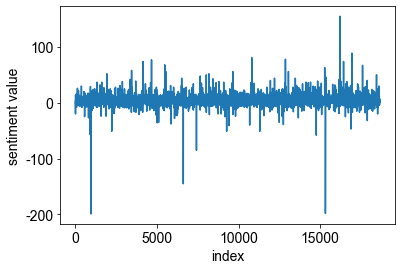

In [79]:
#第12501為離群值
our_sentiment_value['sentiment_value'] = our_sentiment_value['sentiment_value'] .apply(lambda x: 0 if x >
                                                                                       27470 else x)
fig, ax = plt.subplots()
ax.plot(our_sentiment_value['index'], our_sentiment_value["sentiment_value"])
ax.set_xlabel('index')
ax.set_ylabel('sentiment value')

可看出安全信件的情緒大多為中性